# Exploration of earthquake damage in Nepal

In this notebook the dataset provided by drivendata.org is scientifically explored. This dataset is provided as a part of the "Richter's Predictor: Modeling Earthquake Damage" competition that can be found under the following URL: https://www.drivendata.org/competitions/57/nepal-earthquake/

Our goal is to predict the damage grade on a score of three by analysing features of the building.

### Preliminaries

Importing the required dependencies.

In [1]:
# enables referencing modules in repository
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features
# from src.data import make_dataset 
# commented out because: there seems to be an issue at the moment with the initial method from make_dataset
from src.models import train_model
from src.models import predict_model
from src.visualization import visualize

Loading the data.

In [2]:
train_df = pd.read_csv('../data/raw/train_values.csv')
target_df = pd.read_csv('../data/raw/train_labels.csv')

### General Properties

Let us get a first overview of the dataset.

In [3]:
print('number of rows:', len(train_df))
print('number of columns:', len(train_df.columns))

number of rows: 260601
number of columns: 39


In [4]:
pd.options.display.max_columns = None
train_df.head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
5,333020,8,558,6089,2,10,9,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
6,728451,9,475,12066,2,25,3,4,n,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
7,475515,20,323,12236,2,0,8,6,t,w,q,v,x,s,u,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
8,441126,0,757,7219,2,15,8,6,t,r,q,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
9,989500,26,886,994,1,0,13,4,t,i,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [6]:
train_df.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We have a dataset with 260601 rows and 39 features. These features contain both numerical and categorical data. The categorical data in turn can be divided into binary (True/False) and multiclass features.
- numerical: `building_id`, `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id`, `count_floors_pre_eq`, `age`, `area_percentage`, `height_percentage`, `count_families`
- binary: `has_superstructure...`, `has_secondary_use...`
- multiclass: `land_surface_condition`, `foundation_type`, `roof_type`, `ground_floor_type`, `other_floor_type`, `position`, `plan_configuration`, `legal_ownership_status`

## Feature Description
---
In the following the features of the dataset are described. This is done by evaluating the name, datatype and values of the feature to try to predict its usage. Deeper analysis for each feature is further described after the following list:

1. `building_id` seems to be used to identify each unique building.
2. `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id` these features seem to describe the location the building is located in.
3. `count_floors_pre_eq` seems to be the number of floors the building had before the earthquake happend
4. `age` seems to be the age of the building before it was destroyed
5. `area_percentage` maybe the amount of buildings in an area 
6. `height_percentage` likely the height of the building before it was destroyed
7. `land_surface_condition` likely the condition the surface of the ground of the building had before the earthquake
8. `foundation_type` as the name suggests this seems to be the type of the foundation the building was built 
9. `roof_type`, `ground_floor_type`, `other_floor_type` as the name suggest this seems to be the type of the roof and floors the building had. It seems like only to types of floors where recorded
10. `position` (unkown)
11. `plan_configuration` (unkown)
12. `has_superstructure..` likely a one hot encoded feature that represents the type of the superstructure
13. `legal_ownership_status`
14. `count_families` seems to be the amount of families that lived in the building
15. `has_secondary_use..` seems to be a describe wether the building had another purpose than living in it


## [Zahl] Analysis for [feature]
Summary:

### Distribution

### Relation to target value

### Relation to other features

## 1. Analysis for `building_id`
---
This feature describes each unique building that was recorded in the dataset. As the data shows, a total of 260.601 (about a quarter of a million) buildings where recorded in this dataset. As this feature only describes a number that is unique to each building, no further analysis is conducted here as no more information gain is expected.

In [7]:
train_df.building_id.count()

260601

## 2. Analysis for `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id`
---
These features seem to describe the location the building is located in. It could be that 
* geo_level_1_id represents the region in which the building is located.
* geo_level_2_id represents the municipality in which the building is located.
* geo_level_3_id represents the specific area within the municipality in which the building is located.

Summary of the analysis below:
* Some regions have a high count with more than 15.000 recorded buildings while most regions have below 5000 recorded buildings.
* Region 17 has by far the highest amount of damage grade 3 buildings. It seems to be a the epicenter of the earthquake

In [24]:
geo_level_columns = [
    'geo_level_1_id',
    'geo_level_2_id',
    'geo_level_3_id'
]

train_df[geo_level_columns].head(10)

,geo_level_1_id,geo_level_2_id,geo_level_3_id
0,6,487,12198
1,8,900,2812
2,21,363,8973
3,22,418,10694
4,11,131,1488
5,8,558,6089
6,9,475,12066
7,20,323,12236
8,0,757,7219
9,26,886,994


### Distribution
The geo_level feature describes for each unique building where it is located. Let's see how the buildings are distributed for the highest level.

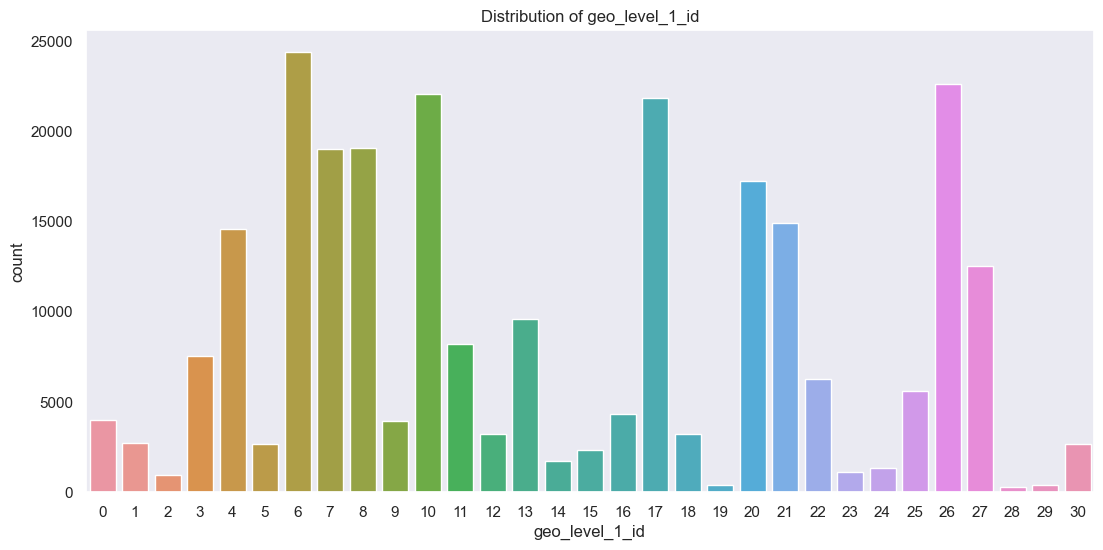

In [86]:
plt.figure(figsize=(13,6))
sns.countplot(data=train_df, x='geo_level_1_id')
plt.title("Distribution of geo_level_1_id")
plt.show()


In the graph above we can see the distribution of the region each recorded building is located at. Some regions have a high count with more than 15.000 recorded buildings while most regions have below 5000 recorded buildings.

### Relation to target value


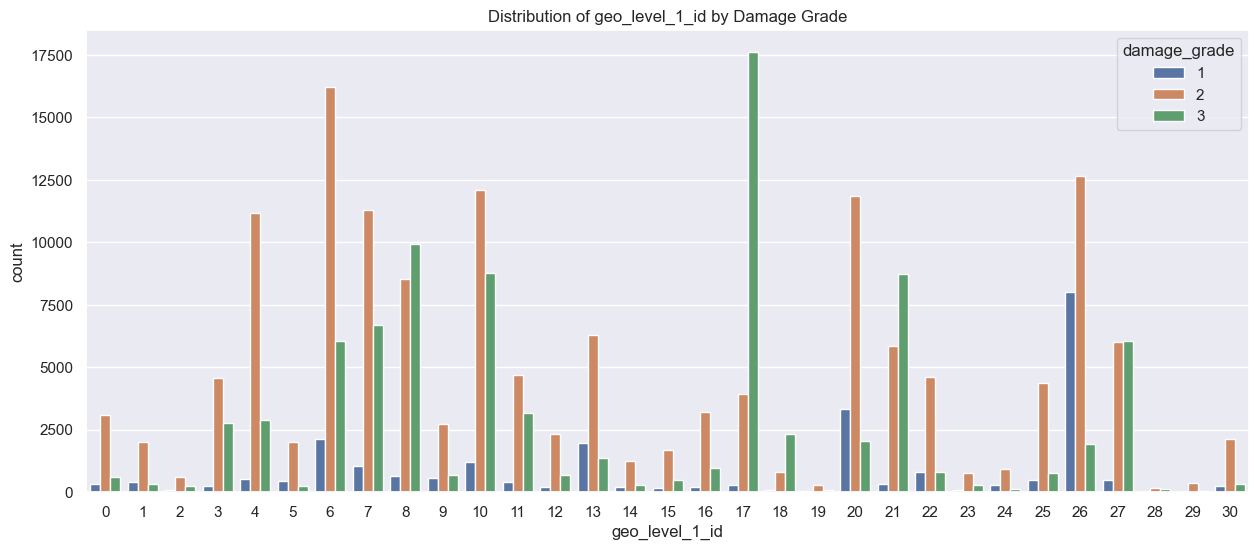

In [61]:
# merge the two dataframes on building_id
merged_df = pd.merge(train_df, target_df, on='building_id')
plt.figure(figsize=(15,6))
sns.countplot(data=merged_df, x="geo_level_1_id", hue="damage_grade")
plt.title("Distribution of geo_level_1_id by Damage Grade")
plt.show()

The graph shows that region 17 seems to have had the most significant earthquake impact. The propability of damage grade 3 is very high if a building belongs to this region.

### Relation to other features

In [103]:
corr_matrix = merged_df.select_dtypes(include=[np.number]).corr()
corr_geo_level_1_id = corr_matrix['geo_level_1_id'].sort_values(ascending=False)
print(corr_geo_level_1_id)

geo_level_1_id                            1.000000
has_superstructure_timber                 0.144985
has_superstructure_cement_mortar_brick    0.134121
has_superstructure_bamboo                 0.074169
area_percentage                           0.071158
count_families                            0.035108
has_superstructure_cement_mortar_stone    0.023656
has_secondary_use_rental                  0.023523
has_superstructure_other                  0.022670
has_superstructure_rc_non_engineered      0.016454
has_superstructure_rc_engineered          0.015767
has_superstructure_stone_flag             0.007677
has_secondary_use_institution             0.003700
has_secondary_use_school                  0.002977
geo_level_3_id                            0.002718
has_secondary_use_industry                0.002655
has_secondary_use_hotel                   0.001911
has_secondary_use_gov_office              0.001060
has_secondary_use_use_police              0.000523
has_secondary_use_health_post  

A positive value indicates a positive correlation, meaning that as one variable increases, the other variable tends to increase as well. In this case, we can see that `has_superstructure_timber` and `has_superstructure_cement_mortar_brick` have the strongest positive correlation with `geo_level_1_id`.

A negative value indicates a negative correlation, meaning that as one variable increases, the other variable tends to decrease. In this case, we can see that `has_superstructure_mud_mortar_stone`, `count_floors_pre_eq`, and `damage_grade` have the strongest negative correlation with `geo_level_1_id`, followed by `height_percentage`and `geo_level_2_id`

## 3. Analysis for `count_floors_pre_eq` [to-do]
---

The "count_floors_pre_eq" feature represents the number of floors in the building before the earthquake, and its possible values are integers from 1 to 9. The data is showing that most buildings had a height of 2 to 3 floors. The maximum size of a building has 9 floors.

### Distribution

In [8]:
train_df.count_floors_pre_eq.value_counts()

count_floors_pre_eq
2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
8         1
9         1
Name: count, dtype: int64

### Relationship to target value

## 4. analysis for `age`
---
Summary of the analysis below:
1. The age feature is unbalanced with the age of the buildings going up to the maximum of age 995 years. However most buildings have an age below 40 years.
2. The exploration of the feature shows a trend regarding the damage grade type 1. The older the buildings are there is less damage of type 1. In fact for buildings that are older than 30 years damage of type 1 is no longer seen.
3. The age feature has no siginificant correlation to other features in the dataset


### Distribution

In [9]:
# lets see what the max value is
train_df.age.max()

995

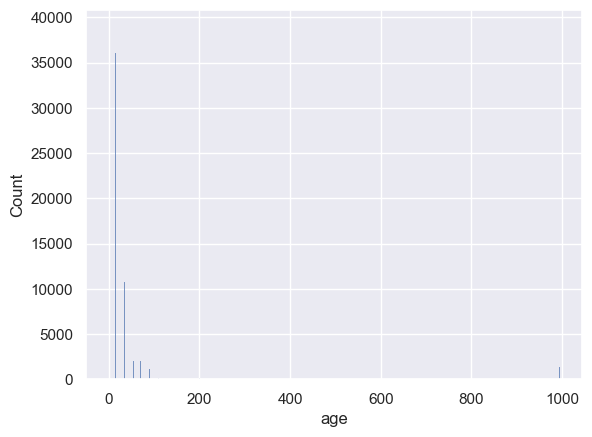

In [10]:
# Lets take a first look at the distribution
sns.set(style="darkgrid")
sns.histplot(train_df, x="age")
plt.show()

A first look at the distribution of the age value shows, that most buildings have an age below 200 years with a wide gap to some buildings that have about 900-1000 years. In the following we take a deeper look on the buildings below the age of 200 years as this part will propably be the most interesting for our prediction.

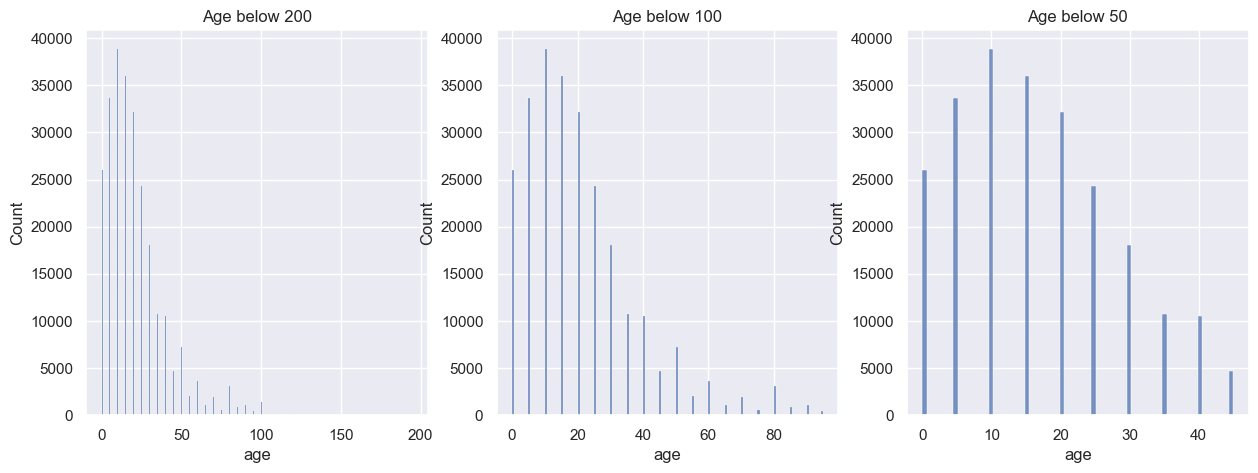

In [11]:
# as the graph shows most buildings are below the age of 200
# lets remove outliers and create a new graph

# merge the two dataframes on building_id
merged_df = pd.merge(train_df, target_df, on='building_id')

threshold1 = 200
threshold2 = 100
threshold3 = 50

temp_df1 = merged_df[merged_df['age'] < threshold1]
temp_df2 = merged_df[merged_df['age'] < threshold2]
temp_df3 = merged_df[merged_df['age'] < threshold3]

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first graph in the first subplot
sns.histplot(temp_df1['age'], ax=axs[0])
axs[0].set_title(f'Age below {threshold1}')

# Plot the second graph in the second subplot
sns.histplot(temp_df2['age'], ax=axs[1])
axs[1].set_title(f'Age below {threshold2}')

# Plot the third graph in the third subplot
sns.histplot(temp_df3['age'], ax=axs[2])
axs[2].set_title(f'Age below {threshold3}')

plt.show()

The graphs above show, that most recorded buildings had an age below 40 years.

### Relation to the target value
We now know the age most of the buildings in the dataset have. In the following the relation to the damage grade is analysed.

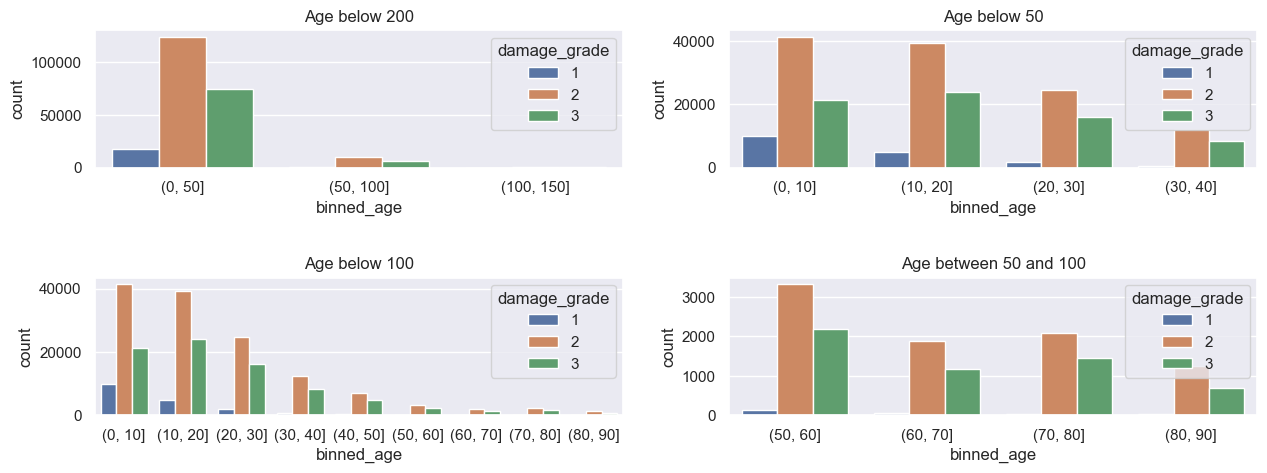

In [12]:
threshold1 = 200
threshold2 = 100
threshold3 = 50
threshold4 = 100

temp_df1 = merged_df.copy()
temp_df2 = merged_df.copy()
temp_df3 = merged_df.copy()
temp_df4 = merged_df.copy()

temp_df1["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold1,50)))
temp_df2["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold2,10)))
temp_df3["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold3,10)))
temp_df4["binned_age"] = pd.cut(merged_df['age'], bins=list(range(50,threshold4,10)))

fig, axs = plt.subplots(2, 2, figsize=(15, 5))
# set the vertical spacing between the subplots
plt.subplots_adjust(hspace=0.8)

# Plot the first graph in the first subplot
sns.countplot(data=temp_df1, x='binned_age', hue='damage_grade', ax=axs[0][0])
axs[0][0].set_title(f'Age below {threshold1}')

# Plot the second graph in the second subplot
sns.countplot(data=temp_df2, x='binned_age', hue='damage_grade', ax=axs[1][0])
axs[1][0].set_title(f'Age below {threshold2}')

# Plot the third graph in the third subplot
sns.countplot(data=temp_df3, x='binned_age', hue='damage_grade', ax=axs[0][1])
axs[0][1].set_title(f'Age below {threshold3}')

# Plot the forth graph in the forth subplot
sns.countplot(data=temp_df4, x='binned_age', hue='damage_grade', ax=axs[1][1])
axs[1][1].set_title(f'Age between 50 and {threshold4}')

plt.show()

The graphs allow us to take a deeper look into the relation of the buildings age towards the damage grade it received from the earthquake. Interestingly there seems to be a trend with buildings that get older having a higher damage grade. In fact buildings that have an age above 30 years no longer have a damage grade of type 1 reported. (with the expection of some outliers at the age of 50 - 60 years).

### Relation to other features
As we can see in the analysis below. The age feature doesn't seem to have a relation to another feature in the dataset.

In [104]:
corr_matrix = merged_df.select_dtypes(include=[np.number]).corr()
corr_age = corr_matrix['age'].sort_values(ascending=False)
print(corr_age)

age                                       1.000000
count_floors_pre_eq                       0.086668
has_superstructure_mud_mortar_brick       0.079525
has_superstructure_adobe_mud              0.068032
height_percentage                         0.061074
damage_grade                              0.029273
geo_level_2_id                            0.012594
has_superstructure_stone_flag             0.009129
has_superstructure_timber                 0.005855
count_families                            0.005309
has_superstructure_mud_mortar_stone       0.001321
has_secondary_use_rental                  0.001193
has_secondary_use_use_police             -0.001195
building_id                              -0.001476
has_superstructure_other                 -0.001520
has_secondary_use_gov_office             -0.001764
has_secondary_use_health_post            -0.002169
has_secondary_use_agriculture            -0.002194
has_secondary_use_school                 -0.003514
has_secondary_use_industry     

## Analysis of target value
---

Let us examine the target.

In [13]:
target_df.head(10)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
5,333020,2
6,728451,3
7,475515,1
8,441126,2
9,989500,1


In [14]:
target_df['damage_grade'].value_counts()

damage_grade
2    148259
3     87218
1     25124
Name: count, dtype: int64

First off, there are three different damage_grades. Furthermore, we observe that the target is higly imbalanced.

### Analysis of missing and default values, as well as finding uninformative columns

Let us examine if there are any missing values (NaN) and if there are duplicate rows.

In [15]:
print('missing values:', train_df.isnull().values.any())
print('duplicate rows:', train_df.duplicated().any())

missing values: False
duplicate rows: False


Let us examine whether there are duplicate columns.

Let us check if there are uninformative columns.

### Analysis of relationships between features

#### Correlations between features

#### Analysis of potential one-hot encodings
The dataset seems to contain features whose values are mutually exclusive. These are the `has_superstructure` features and the `has_secondary_use` features to be exact. We assume that they might be the results of one-hot encodings. Let us examine this.

In [16]:
has_superstructure_columns = [
    'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone', 
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 
    'has_superstructure_timber',
    'has_superstructure_bamboo', 
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 
    'has_superstructure_other'
]

train_df[has_superstructure_columns].head(10)

,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
0,1,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,1,1,0,0,0,0
8,0,1,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,0


In [17]:
print('train_df[has_superstructure_columns] is one-hot encoded:', build_features.is_one_hot_encoded(train_df[has_superstructure_columns]))

train_df[has_superstructure_columns] is one-hot encoded: False


We see in the first sample, that the features `has_superstructure_adobe_mud` and `has_superstructure_mud_mortar_stone` both have the value 1. Therefore, our assumption that the `has_superstructure` features are one-hot encoded is false. This observation is supported by the result of the `is_one_hot_encoded` operation that checks whether each row contains exactly one 1 with the rest being 0. In conclusion, a building can have multiple superstructures.

In [18]:
has_secondary_use_columns = [
    'has_secondary_use',
    'has_secondary_use_agriculture', 
    'has_secondary_use_hotel',
    'has_secondary_use_rental', 
    'has_secondary_use_institution',
    'has_secondary_use_school', 
    'has_secondary_use_industry',
    'has_secondary_use_health_post', 
    'has_secondary_use_gov_office',
    'has_secondary_use_use_police', 
    'has_secondary_use_other'
]

train_df[has_secondary_use_columns].head(10)

,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0


We observe in the first sample, that there is not a single occurence of 1. Furthermore, in the sixth sample both `has_secondary_use` and `has_secondary_use_agriculture` are both 1. From this we could conclude, that this also is not a one-hot encoding. But we also observe, that `has_secondary_use` only is 1 if one of the other values is 1. Let us replace this feature with its complement `has_no_secondary_use`. The information in the dataset stays the same.

In [19]:
has_secondary_use_df = pd.DataFrame(train_df[has_secondary_use_columns])

has_secondary_use_df['has_no_secondary_use'] = has_secondary_use_df['has_secondary_use'].replace({0:1, 1:0})
has_secondary_use_df = has_secondary_use_df.drop(columns=['has_secondary_use'])

has_secondary_use_df.head(10)

,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,has_no_secondary_use
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,1


In [20]:
print('has_secondary_use_df is one-hot encoded:', build_features.is_one_hot_encoded(has_secondary_use_df))

has_secondary_use_df is one-hot encoded: False


Although the presented section of the dataframe shows a one-hot encoding, our `is_one_hot_encoded` function returns that the whole dataframe is not one-hot encoded. Let us examine the rows where this is not the case.

In [21]:
not_one_hot_encoded_rows = has_secondary_use_df[has_secondary_use_df.sum(axis=1) >= 2]

print('number of not one-hot encoded rows:', len(not_one_hot_encoded_rows))
print('values of', not_one_hot_encoded_rows['has_secondary_use_other'].value_counts())
not_one_hot_encoded_rows.head(10)

number of not one-hot encoded rows: 557
values of has_secondary_use_other
1    557
Name: count, dtype: int64


,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,has_no_secondary_use
304,1,0,0,0,0,0,0,0,0,1,0
1408,1,0,0,0,0,0,0,0,0,1,0
1593,1,0,0,0,0,0,0,0,0,1,0
2329,1,0,0,0,0,0,0,0,0,1,0
3704,0,1,0,0,0,0,0,0,0,1,0
4662,1,0,0,0,0,0,0,0,0,1,0
4785,1,0,0,0,0,0,0,0,0,1,0
4972,1,0,0,0,0,0,0,0,0,1,0
5002,1,0,0,0,0,0,0,0,0,1,0
5359,1,0,0,0,0,0,0,0,0,1,0


We see, that the rows that are not one-hot encoded always have the flag `has_secondary_use_other` set to 1, while the remaining features represent a valid one-hot encoding. In later preprocessing steps, we could think about ignoring the `has_secondary_use_other` flag for these rows (i.e. setting it to 0) and decode this otherwise valid one-hot encoding.

### Conclusions